The Goal

You've just joined the data team at an online publishing company. One of your verticals is a food publication. A product manager on your team wants to build a feature for this vertical that enables users to query by cuisine, not just by ingredients. Most of your recipes are unlabeled, and it's infeasible to label them by hand. Luckily, you have a small training set of about 10,000 recipes with labeled cuisines.

Design and execute a method to predict the cuisine of a recipe given only its ingredients. How could you design this to be robust enough to understand similarities / substitutions between ingredients? For each each major cuisine, what are the driving ingredients that characterize it?

Your product manager indicates a likelihood that you will only need to write a guideline for an outsourced team to hand label the remaining corpus. How would you go about writing this guide for a few major cuisines?

In [1]:
import json
import pandas as pd
import numpy as np


In [2]:
df = pd.read_json('../recipies.json')


In [3]:
df.head()

,cuisine,id,ingredients
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes..."
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g..."
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,indian,22213,"[water, vegetable oil, wheat, salt]"
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe..."


In [4]:
print(df.cuisine.unique())
print(len(df.cuisine.unique()))
print(df.info())

['greek' 'southern_us' 'filipino' 'indian' 'jamaican' 'spanish' 'italian'
 'mexican' 'chinese' 'british' 'thai' 'vietnamese' 'cajun_creole'
 'brazilian' 'french' 'japanese' 'irish' 'korean' 'moroccan' 'russian']
20
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39774 entries, 0 to 39773
Data columns (total 3 columns):
cuisine        39774 non-null object
id             39774 non-null int64
ingredients    39774 non-null object
dtypes: int64(1), object(2)
memory usage: 932.3+ KB
None


In [5]:
print(df.isnull().sum())
print(len(df.id.unique()))
df['ingredients'] = df['ingredients'].apply(', '.join)
print(df.info())
print(df.head())

cuisine        0
id             0
ingredients    0
dtype: int64
39774
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39774 entries, 0 to 39773
Data columns (total 3 columns):
cuisine        39774 non-null object
id             39774 non-null int64
ingredients    39774 non-null object
dtypes: int64(1), object(2)
memory usage: 932.3+ KB
None
       cuisine     id                                        ingredients
0        greek  10259  romaine lettuce, black olives, grape tomatoes,...
1  southern_us  25693  plain flour, ground pepper, salt, tomatoes, gr...
2     filipino  20130  eggs, pepper, salt, mayonaise, cooking oil, gr...
3       indian  22213                  water, vegetable oil, wheat, salt
4       indian  13162  black pepper, shallots, cornflour, cayenne pep...


In [6]:
X = df['ingredients'].values
y = df['cuisine'].values

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.3, random_state = 42)

In [9]:
vect = CountVectorizer()       
Xt = vect.fit_transform(X_train)
#build the model - we have 20 cuisines
n_cuisines = 20
lda = LatentDirichletAllocation(n_components = n_cuisines, 
                                learning_method = 'batch', 
                                max_iter = 20, 
                                random_state = 42)
recipe_type = lda.fit_transform(Xt)
print(lda.components_.shape)
#Sort the features in descending order to see the most important ones on top
sort_features = np.argsort(lda.components_, axis=1)[:, ::-1]
#Store the feature names in a numpy array:
features = np.array(vect.get_feature_names())
#Check out top 4 ingredients for each group (cuisine?)
top4words = ["{:>2} ".format(i) + " ".join(words)
                for i, words in enumerate(features[sort_features[:, :4]])]
top4words

(20, 2815)


[' 0 wine white parsley leaf',
 ' 1 fresh lime cilantro juice',
 ' 2 sugar butter vanilla cream',
 ' 3 sesame oil sauce vinegar',
 ' 4 potatoes carrots onions salt',
 ' 5 water yeast dry warm',
 ' 6 ground cumin coriander ginger',
 ' 7 pepper red oil olive',
 ' 8 chicken boneless skinless breasts',
 ' 9 rice pepper green onions',
 '10 butter eggs salt pepper',
 '11 lemon juice orange fresh',
 '12 olive oil fresh extra',
 '13 cheese parmesan grated mozzarella',
 '14 mustard mayonaise dijon greens',
 '15 sauce oil soy garlic',
 '16 flour all purpose salt',
 '17 fat cooking low sodium',
 '18 cheese corn tortillas cream',
 '19 pepper ground garlic salt']

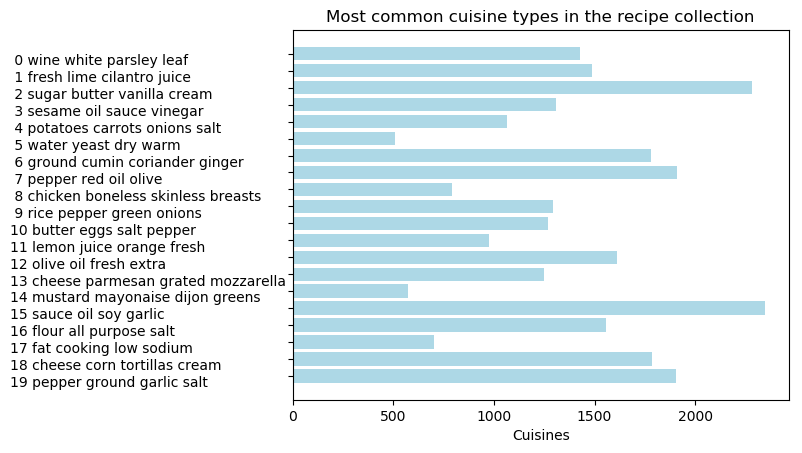

In [10]:
%matplotlib inline  
plt.rcdefaults()
fig, ax = plt.subplots()

ax.barh(np.arange(n_cuisines), np.sum(recipe_type, axis = 0), color='lightblue', ecolor='black')
ax.set_yticks(np.arange(n_cuisines))
ax.set_yticklabels(top4words, ha='left', va='top')
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Cuisines')
ax.set_title('Most common cuisine types in the recipe collection')
yax = ax.get_yaxis()
yax.set_tick_params(pad=200)

plt.show()

Although some of these are just condiments (7, 19), others do seem to fit the cuisine list. 0 might be french cuisine, 18 might be mexican cuisine, 13 might be italian, etc). Perhaps if I fine tune the parameters a bit more it might get closer to our 20 cuisine classes. Also, as a next step, it might help to eliminate some very common ingredients in the CountVectorizer step (like salt and pepper).

In [11]:
vec = HashingVectorizer()   #ngram_range=(1,2)
c_train = vec.fit_transform(X_train)
c_test = vec.transform(X_test)

Accuracy:  0.6937065281153105
Classification report:                precision    recall  f1-score   support

   brazilian       0.71      0.45      0.55       147
     british       0.54      0.29      0.37       242
cajun_creole       0.71      0.57      0.63       495
     chinese       0.63      0.86      0.72       760
    filipino       0.61      0.34      0.44       200
      french       0.54      0.50      0.52       820
       greek       0.73      0.45      0.56       354
      indian       0.76      0.86      0.81       899
       irish       0.69      0.33      0.45       207
     italian       0.65      0.90      0.76      2351
    jamaican       0.82      0.36      0.50       135
    japanese       0.82      0.59      0.69       443
      korean       0.76      0.47      0.58       249
     mexican       0.80      0.89      0.84      1957
    moroccan       0.82      0.43      0.56       237
     russian       0.64      0.21      0.31       144
 southern_us       0.64    

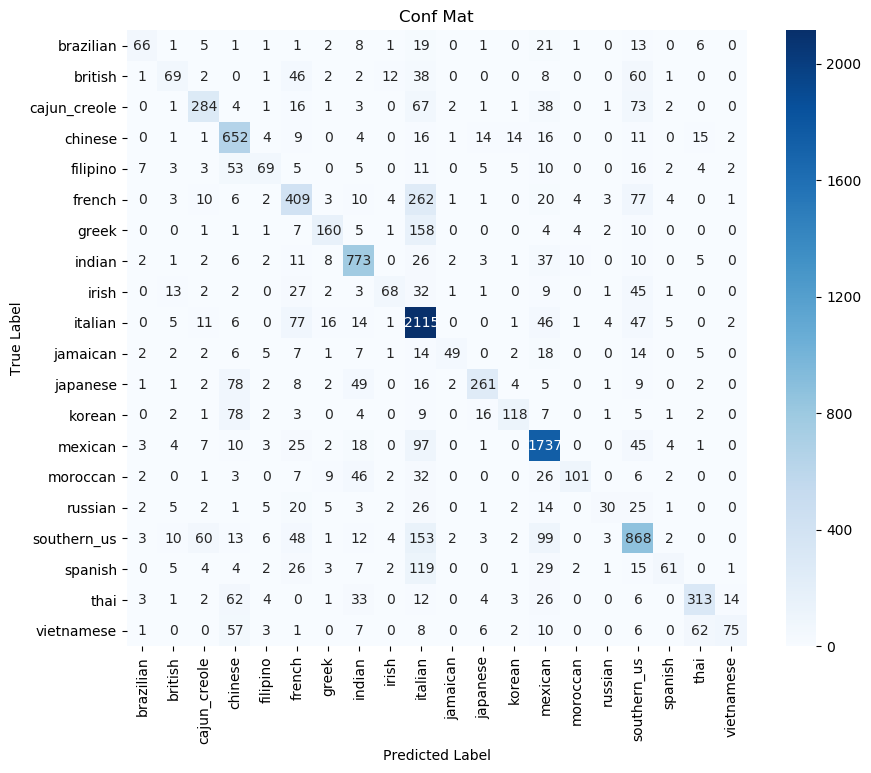

In [12]:
rfc = RandomForestClassifier(n_estimators = 15, random_state = 42)
rfc.fit(c_train, y_train)
pred = rfc.predict(c_test)
print("Accuracy: ", metrics.accuracy_score(y_test, pred))
cf = metrics.confusion_matrix(y_test,pred)
cf_df = pd.DataFrame(cf)
print('Classification report: ', metrics.classification_report(y_test, pred))
clf_report = metrics.classification_report(y_test, pred, output_dict=True)
labels = list(clf_report.keys())[:20]
plt.figure(figsize = (10,8))
sns.heatmap(cf_df, cmap = "Blues",annot = True, fmt='g', xticklabels = labels, yticklabels = labels)
plt.title("Conf Mat")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

In order to write the guideline for the labelling team, I can get the list of ingredients that are most common in each cuisine to identify within a new recipe, and assign a score (weight) towards that cuisine (for instance, curry for indian cuisine or mozzarela for italian would give a high weight to that recipe towards their respective cuisines). 

Accuracy:  0.708706947121428
Classification report:                precision    recall  f1-score   support

   brazilian       0.71      0.48      0.57       147
     british       0.45      0.24      0.31       242
cajun_creole       0.73      0.64      0.68       495
     chinese       0.66      0.86      0.75       760
    filipino       0.66      0.40      0.49       200
      french       0.49      0.51      0.50       820
       greek       0.75      0.54      0.63       354
      indian       0.77      0.88      0.82       899
       irish       0.72      0.28      0.40       207
     italian       0.69      0.89      0.78      2351
    jamaican       0.81      0.39      0.52       135
    japanese       0.82      0.59      0.68       443
      korean       0.87      0.51      0.64       249
     mexican       0.82      0.91      0.86      1957
    moroccan       0.80      0.52      0.63       237
     russian       0.64      0.19      0.29       144
 southern_us       0.62     

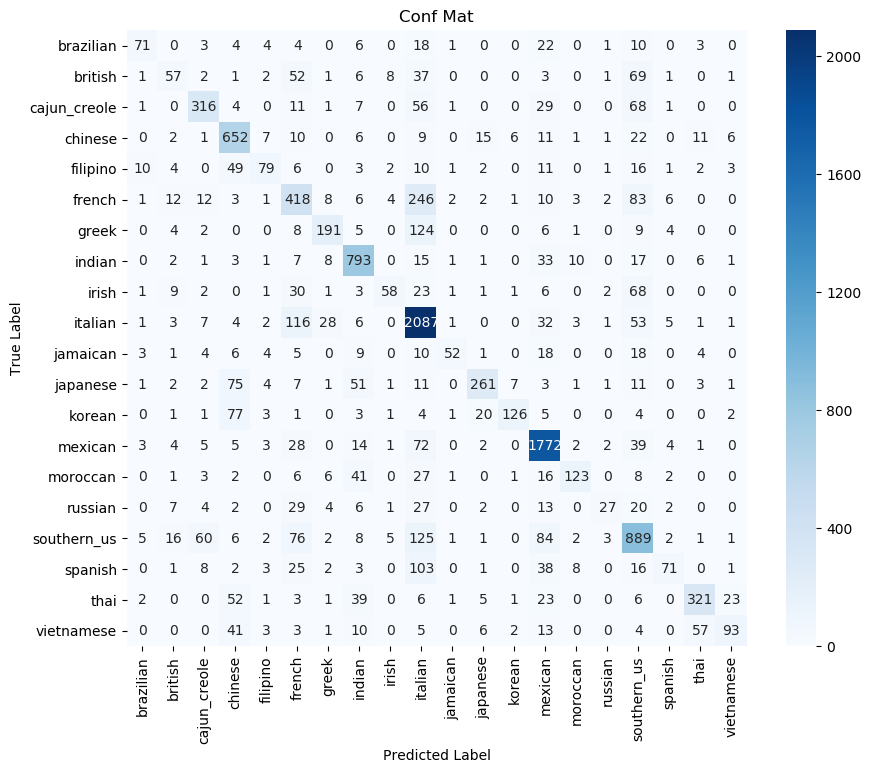

In [13]:
#Try the tf-idf as well
tf_vec = TfidfVectorizer()    #ngram_range=(1,2,3)
c_train_tf = tf_vec.fit_transform(X_train)
c_test_tf = tf_vec.transform(X_test)
rfc1 = RandomForestClassifier(n_estimators = 15, random_state = 42)
rfc1.fit(c_train_tf, y_train)
pred_tf = rfc1.predict(c_test_tf)
print("Accuracy: ", metrics.accuracy_score(y_test, pred_tf))
cf_tf = metrics.confusion_matrix(y_test,pred_tf)
cf_tf_df = pd.DataFrame(cf_tf)
print('Classification report: ', metrics.classification_report(y_test, pred_tf))
clf_report = metrics.classification_report(y_test, pred_tf, output_dict=True)
labels = list(clf_report.keys())[:20]
plt.figure(figsize = (10,8))
sns.heatmap(cf_tf_df, cmap = "Blues",annot = True, fmt='g', xticklabels = labels, yticklabels = labels)

plt.title("Conf Mat")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

Accuracy:  0.7260538003854856
Classification report:                precision    recall  f1-score   support

   brazilian       0.70      0.53      0.60       147
     british       0.47      0.31      0.38       242
cajun_creole       0.74      0.64      0.69       495
     chinese       0.68      0.85      0.75       760
    filipino       0.55      0.36      0.43       200
      french       0.54      0.54      0.54       820
       greek       0.70      0.63      0.66       354
      indian       0.79      0.89      0.83       899
       irish       0.62      0.37      0.46       207
     italian       0.73      0.88      0.80      2351
    jamaican       0.85      0.52      0.65       135
    japanese       0.76      0.62      0.69       443
      korean       0.76      0.57      0.65       249
     mexican       0.84      0.90      0.87      1957
    moroccan       0.81      0.54      0.65       237
     russian       0.65      0.33      0.44       144
 southern_us       0.68    

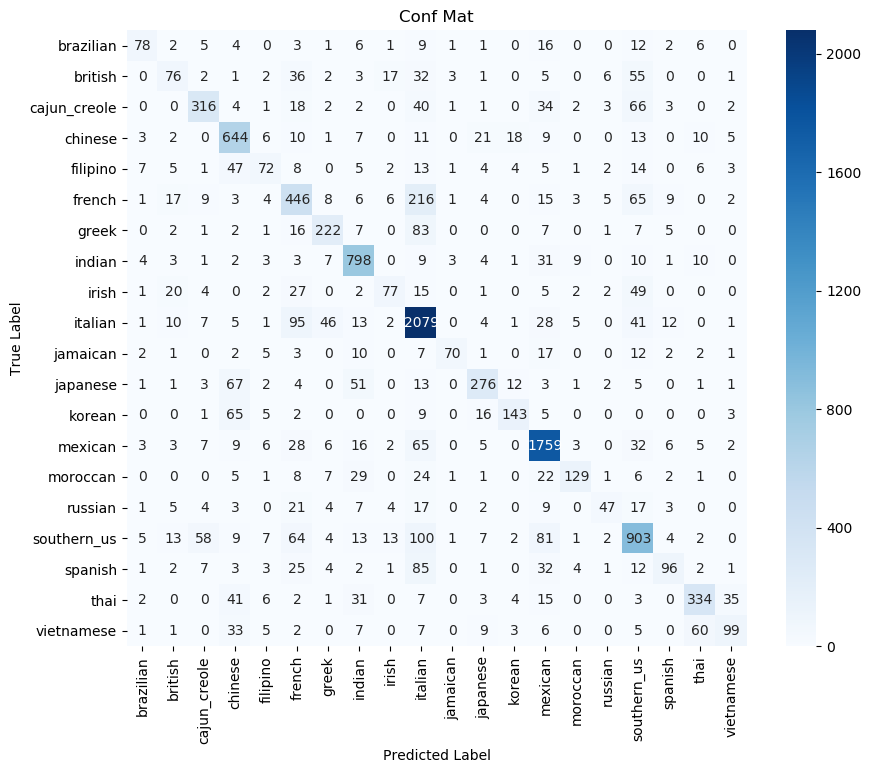

In [14]:
#Try the CountVectorizer (BoW) as well
cv_vec = CountVectorizer(max_features = 1000, max_df = .25)    #ngram_range=(1,2,3)
c_train_cv = cv_vec.fit_transform(X_train)
c_test_cv = cv_vec.transform(X_test)
rfc2 = RandomForestClassifier(n_estimators = 15, random_state = 42)
rfc2.fit(c_train_cv, y_train)
pred_cv = rfc2.predict(c_test_cv)
print("Accuracy: ", metrics.accuracy_score(y_test, pred_cv))
cf_cv = metrics.confusion_matrix(y_test,pred_cv)
cf_cv_df = pd.DataFrame(cf_cv)
print('Classification report: ', metrics.classification_report(y_test, pred_cv))
clf_report = metrics.classification_report(y_test, pred_cv, output_dict=True)
labels = list(clf_report.keys())[:20]

plt.figure(figsize = (10,8))
sns.heatmap(cf_cv_df, cmap = "Blues",annot = True, fmt='g', xticklabels = labels, yticklabels = labels)
plt.title("Conf Mat")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

Try MultinomialNB


Accuracy:  0.6692365708539345
Classification report:                precision    recall  f1-score   support

   brazilian       0.97      0.19      0.32       147
     british       0.83      0.04      0.08       242
cajun_creole       0.83      0.47      0.60       495
     chinese       0.57      0.91      0.70       760
    filipino       0.95      0.09      0.16       200
      french       0.53      0.41      0.47       820
       greek       0.88      0.29      0.44       354
      indian       0.75      0.90      0.82       899
       irish       0.92      0.05      0.10       207
     italian       0.65      0.91      0.76      2351
    jamaican       1.00      0.12      0.21       135
    japanese       0.92      0.52      0.67       443
      korean       0.96      0.28      0.43       249
     mexican       0.80      0.91      0.85      1957
    moroccan       0.95      0.29      0.45       237
     russian       1.00      0.02      0.04       144
 southern_us       0.50    

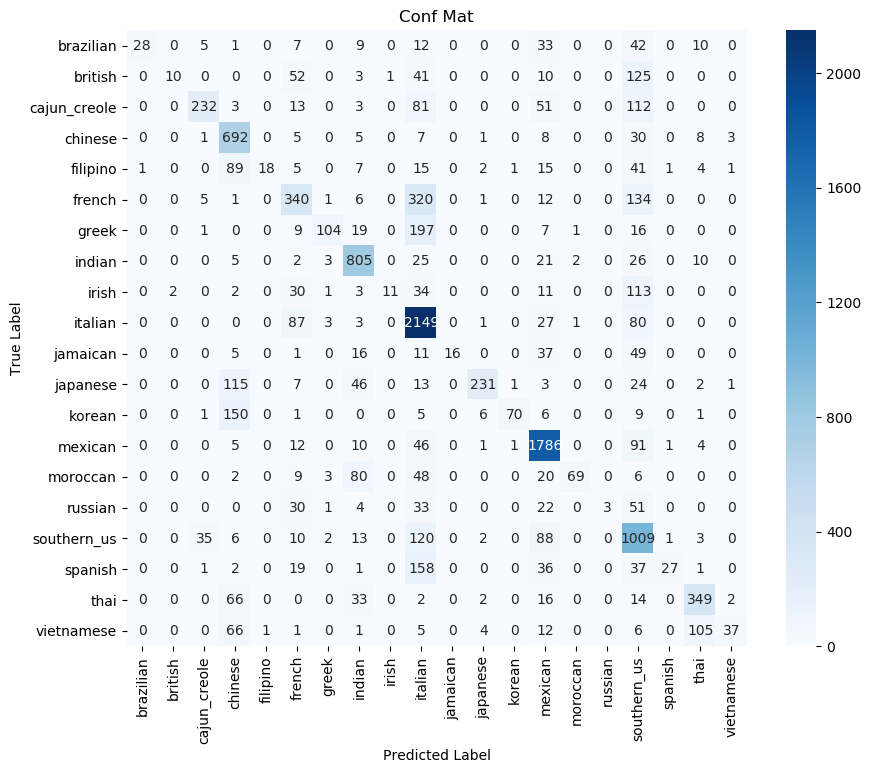

In [15]:
nb = MultinomialNB()
nb.fit(c_train_tf, y_train)
nb_pred = nb.predict(c_test_tf)

print("Accuracy: ", metrics.accuracy_score(y_test, nb_pred))
nb_cf = metrics.confusion_matrix(y_test,nb_pred)
nb_cf_df = pd.DataFrame(nb_cf)
print('Classification report: ', metrics.classification_report(y_test, nb_pred))
clf_report = metrics.classification_report(y_test, nb_pred, output_dict=True)
labels = list(clf_report.keys())[:20]

plt.figure(figsize = (10,8))
sns.heatmap(nb_cf_df, cmap = "Blues",annot = True, fmt='g', xticklabels = labels, yticklabels = labels)
plt.title("Conf Mat")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

The bag of words (Count Vectorizer) approach had the best result of the methods tried.
